In [1]:
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

/home/dongqi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dongqi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dongqi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dongqi/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

# Data Collection

In [2]:
train_data = pd.read_csv('train.csv', parse_dates=['timestamp'])
train_weather = pd.read_csv('weather_train.csv', parse_dates=['timestamp'])
building_data = pd.read_csv('building_metadata.csv')

## Reduce Memory Usage

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train_data = reduce_mem_usage(train_data)
train_weather = reduce_mem_usage(train_weather)
building_data = reduce_mem_usage(building_data)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [5]:
def plot_bar(data, name):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    data_label = data[name].value_counts()
    dict_train = dict(zip(data_label.keys(), ((data_label.sort_index())).tolist()))
    names = list(dict_train.keys())
    values = list(dict_train.values())
    plt.bar(names, values)
    ax.set_xticklabels(names, rotation=45)
    plt.grid()
    plt.show()

# MISSING VALUE Pre-Process

In [6]:
cols_with_missing_train_weather = [col for col in train_weather.columns if train_weather[col].isnull().any()]
cols_with_missing_building = [col for col in building_data.columns if building_data[col].isnull().any()]

In [7]:
print(cols_with_missing_train_weather)
print(cols_with_missing_building)

['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
['year_built', 'floor_count']


In [8]:
train_weather

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.093750,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.000000,NaN,-8.000000,NaN,NaN,180.0,5.699219
139769,15,2016-12-31 20:00:00,2.800781,2.0,-8.898438,NaN,1007.5,180.0,7.699219
139770,15,2016-12-31 21:00:00,2.800781,NaN,-7.199219,NaN,1007.5,180.0,5.101562
139771,15,2016-12-31 22:00:00,2.199219,NaN,-6.699219,NaN,1008.0,170.0,4.601562


In [9]:
building_data

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [10]:
train_weather.isnull().sum(axis=0)

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [11]:
building_data.isnull().sum(axis=0)

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

### Replace Missing Value with 'median'

In [13]:
imp_most = SimpleImputer(strategy='median')
train_weather[cols_with_missing_train_weather] = imp_most.fit_transform(train_weather[cols_with_missing_train_weather])
building_data[cols_with_missing_building] = imp_most.fit_transform(building_data[cols_with_missing_building])

# Data Cleaning

In [14]:
train_data['meter_reading'] = np.log1p(train_data['meter_reading'])

In [15]:
train_data['month'] = train_data['timestamp'].dt.month
train_data['day'] = train_data['timestamp'].dt.weekday
train_data['year'] = train_data['timestamp'].dt.year
train_data['hour'] = train_data['timestamp'].dt.hour

In [16]:
train_data['weekend'] = np.where((train_data['day'] == 5) | (train_data['day'] == 6), 1, 0)

In [17]:
train_weather['wind_direction'+'_sin'] = np.sin((2*np.pi*train_weather['wind_direction'])/360)
train_weather['wind_direction'+'_cos'] = np.cos((2*np.pi*train_weather['wind_direction'])/360)
train_weather = train_weather.drop(['wind_direction'], axis=1)

In [18]:
train_data = pd.get_dummies(train_data, columns=['meter'])

In [19]:
features_cyc = {'month' : 12, 'day' : 7, 'hour' : 24}
for feature in features_cyc.keys():
    train_data[feature+'_sin'] = np.sin((2*np.pi*train_data[feature])/features_cyc[feature])
    train_data[feature+'_cos'] = np.cos((2*np.pi*train_data[feature])/features_cyc[feature])
train_data = train_data.drop(features_cyc.keys(), axis=1)

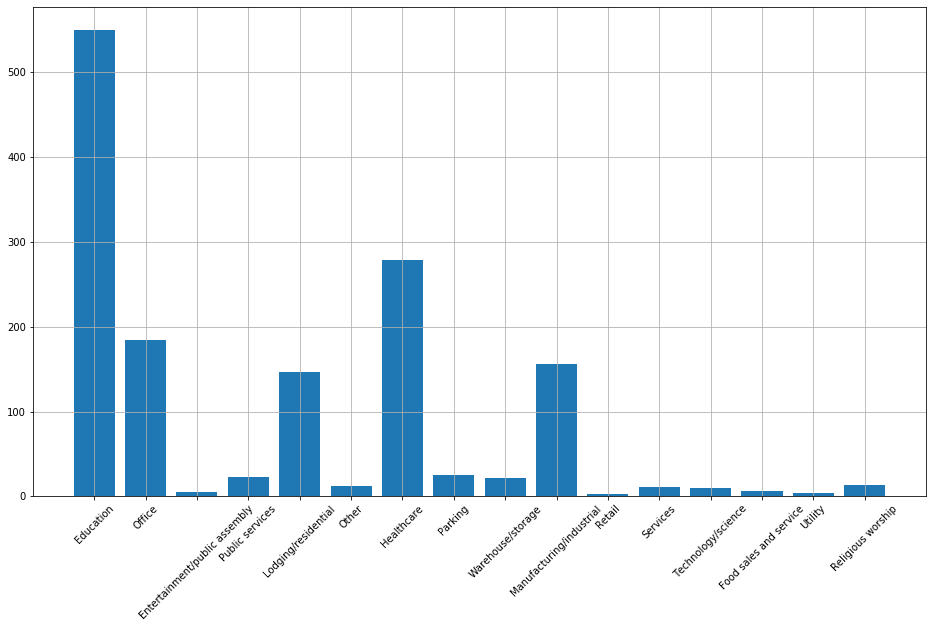

In [20]:
plot_bar(building_data, 'primary_use')

In [21]:
map_use = dict(zip(building_data['primary_use'].value_counts().sort_index().keys(),
                     range(1, len(building_data['primary_use'].value_counts())+1)))


In [22]:
map_use

{'Education': 1,
 'Entertainment/public assembly': 2,
 'Food sales and service': 3,
 'Healthcare': 4,
 'Lodging/residential': 5,
 'Manufacturing/industrial': 6,
 'Office': 7,
 'Other': 8,
 'Parking': 9,
 'Public services': 10,
 'Religious worship': 11,
 'Retail': 12,
 'Services': 13,
 'Technology/science': 14,
 'Utility': 15,
 'Warehouse/storage': 16}

In [23]:
building_data['primary_use'] = building_data['primary_use'].replace(map_use)

In [24]:
# weather_scale = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_speed']
weather_scale = ['air_temperature', 'dew_temperature', 'wind_speed']

In [25]:
mean = train_weather[weather_scale].mean(axis=0)
train_weather[weather_scale] = train_weather[weather_scale].astype('float32')
train_weather[weather_scale] -= train_weather[weather_scale].mean(axis=0)
std = train_weather[weather_scale].std(axis=0)
train_weather[weather_scale] /= train_weather[weather_scale].std(axis=0)

In [26]:
#building_scale = ['square_feet', 'year_built', 'floor_count']
building_scale = ['square_feet']

In [27]:
mean = building_data[building_scale].mean(axis=0)
building_data[building_scale] = building_data[building_scale].astype('float32')
building_data[building_scale] -= building_data[building_scale].mean(axis=0)
std = building_data[building_scale].std(axis=0)
building_data[building_scale] /= building_data[building_scale].std(axis=0)

In [28]:
train_weather

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,wind_direction_sin,wind_direction_cos
0,0,2016-01-01 00:00:00,0.995966,6.0,1.292541,0.0,1019.5,-1.524392,0.000000e+00,1.000000
1,0,2016-01-01 01:00:00,0.940082,2.0,1.404305,-1.0,1020.0,-0.881537,9.396926e-01,0.342020
2,0,2016-01-01 02:00:00,0.788605,2.0,1.404305,0.0,1020.0,-1.524392,0.000000e+00,1.000000
3,0,2016-01-01 03:00:00,0.628305,2.0,1.353213,0.0,1020.0,-1.524392,0.000000e+00,1.000000
4,0,2016-01-01 04:00:00,0.525360,2.0,1.292541,-1.0,1020.0,-0.410277,-9.396926e-01,-0.342020
...,...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,-1.074703,2.0,-1.568603,0.0,1016.5,0.918121,1.224647e-16,-1.000000
139769,15,2016-12-31 20:00:00,-1.093454,2.0,-1.660409,0.0,1007.5,1.775261,1.224647e-16,-1.000000
139770,15,2016-12-31 21:00:00,-1.093454,2.0,-1.486776,0.0,1007.5,0.661984,1.224647e-16,-1.000000
139771,15,2016-12-31 22:00:00,-1.150074,2.0,-1.435684,0.0,1008.0,0.447699,1.736482e-01,-0.984808


# Merge Datas

In [29]:
train_data = pd.merge(train_data, building_data, on='building_id', right_index=True)
train_data = train_data.sort_values(['timestamp'])
train_data = pd.merge_asof(train_data, train_weather, on='timestamp', by='site_id', right_index=True)
del train_weather

# Data Generator

In [30]:
class DataGenerator(Sequence):
    """ A data generator based on the template
        https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        """
    
    def __init__(self, data, list_IDs, features, batch_size, shuffle=False):
        self.data = data.loc[list_IDs].copy()
        self.list_IDs = list_IDs
        self.features = features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

        
    def __data_generation(self, list_IDs_temp):        
        X = np.empty((len(list_IDs_temp), len(self.features)), dtype=float)
        y = np.empty((len(list_IDs_temp), 1), dtype=float)
        X = self.data.loc[list_IDs_temp, self.features].values
        
        if 'meter_reading' in self.data.columns:
            y = self.data.loc[list_IDs_temp, 'meter_reading'].values
        # reshape
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
        return X, y

# Initial Model Development

In [31]:
train_size = int(len(train_data.index)*0.95)
val_size = len(train_data.index) - train_size
train_list, val_list = train_data.index[0:train_size], train_data.index[train_size:train_size+val_size]
print(train_size, val_size)

19205295 1010805


In [32]:
for col in train_data.columns:
    print(col)

building_id
timestamp
meter_reading
year
weekend
meter_0
meter_1
meter_2
meter_3
month_sin
month_cos
day_sin
day_cos
hour_sin
hour_cos
site_id
primary_use
square_feet
year_built
floor_count
air_temperature
cloud_coverage
dew_temperature
precip_depth_1_hr
sea_level_pressure
wind_speed
wind_direction_sin
wind_direction_cos


In [33]:
len(train_data)

20216100

In [34]:
no_features = ['building_id', 'timestamp', 'meter_reading', 'year','cloud_coverage','precip_depth_1_hr',
               'sea_level_pressure','wind_direction_sin','wind_direction_cos','year_built','floor_count']
#no_features = ['building_id', 'timestamp', 'meter_reading']
features = train_data.columns.difference(no_features)

In [35]:
features

Index(['air_temperature', 'day_cos', 'day_sin', 'dew_temperature', 'hour_cos',
       'hour_sin', 'meter_0', 'meter_1', 'meter_2', 'meter_3', 'month_cos',
       'month_sin', 'primary_use', 'site_id', 'square_feet', 'weekend',
       'wind_speed'],
      dtype='object')

In [36]:
batch_size = 1024
train_generator = DataGenerator(train_data, train_list, features, batch_size)
val_generator = DataGenerator(train_data, val_list, features, batch_size)

In [37]:
input_dim = len(features)
print(input_dim)

17


In [38]:
model = Sequential()
model.add(LSTM(units=128, activation = 'relu', input_shape=(1, input_dim)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='relu'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [39]:
def rmse(y_true, y_pred):
    """ root_mean_squared_error """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [40]:
model.compile(optimizer = Adam(lr=1e-2),
              loss='mse',
              metrics=[rmse])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               74752     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 140,801
Trainable params: 140,801
Non-trainable params: 0
_________________________________________________________________


In [42]:
epochs = 5

In [43]:
history = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs = epochs)
# history = model.fit_generator(generator=train_generator, epochs = epochs)

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
18755/18755 [==============================] - 5637s 301ms/step - loss: 2.1120 - rmse: 1.4413 - val_loss: 1.6548 - val_rmse: 1.2853
Epoch 2/5
18755/18755 [==============================] - 5620s 300ms/step - loss: 1.8359 - rmse: 1.3440 - val_loss: 1.5575 - val_rmse: 1.2466
Epoch 3/5
18755/18755 [==============================] - 5642s 301ms/step - loss: 1.7690 - rmse: 1.3189 - val_loss: 1.5490 - val_rmse: 1.2433
Epoch 4/5
18755/18755 [==============================] - 5645s 301ms/step - loss: 1.7272 - rmse: 1.3029 - val_loss: 1.5475 - val_rmse: 1.2424
Epoch 5/5
18755/18755 [==============================] - 5643s 301ms/step - loss: 1.6950 - rmse: 1.2905 - val_loss: 1.5352 - val_rmse: 1.2375


# Model Performance

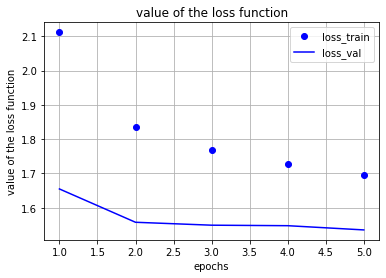

In [44]:
# Analyse results
# A short analysis of the train results.
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

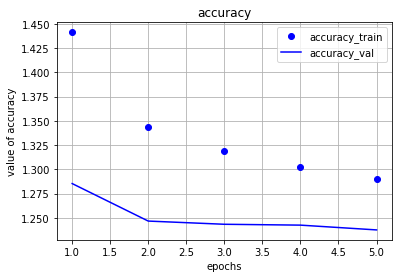

In [45]:
acc = history.history['rmse']
acc_val = history.history['val_rmse']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

In [46]:
del train_data

# Generate Output File

In [47]:
# Predict test data
# We following the steps above to prepare the data
# Build data generator
# Predict subdate
# Write data in an array
nrows = 1667904
batch_size = 1022
steps = 25
y_test = np.empty(())
test_weather = pd.read_csv('weather_test.csv', parse_dates=['timestamp'])
cols_with_missing_test_weather = [col for col in test_weather.columns if test_weather[col].isnull().any()]
test_weather[cols_with_missing_test_weather] = imp_most.fit_transform(test_weather[cols_with_missing_test_weather])

mean = test_weather[weather_scale].mean(axis=0)
test_weather[weather_scale] = test_weather[weather_scale].astype('float32')
test_weather[weather_scale] -= test_weather[weather_scale].mean(axis=0)
std = test_weather[weather_scale].std(axis=0)
test_weather[weather_scale] /= test_weather[weather_scale].std(axis=0)

test_weather['wind_direction'+'_sin'] = np.sin((2*np.pi*test_weather['wind_direction'])/360)
test_weather['wind_direction'+'_cos'] = np.cos((2*np.pi*test_weather['wind_direction'])/360)
test_weather = test_weather.drop(['wind_direction'], axis=1)

for i in range(0, steps):
    print('work on step ', (i+1))
    test_data = pd.read_csv('test.csv', skiprows=range(1,i*(nrows)+1), nrows=nrows, parse_dates=['timestamp'])
    test_data['month'] = test_data['timestamp'].dt.month
    test_data['day'] = test_data['timestamp'].dt.weekday
    test_data['year'] = test_data['timestamp'].dt.year
    test_data['hour'] = test_data['timestamp'].dt.hour
    test_data['weekend'] = np.where((test_data['day'] == 5) | (test_data['day'] == 6), 1, 0)
    for feature in features_cyc.keys():
        test_data[feature+'_sin'] = np.sin((2*np.pi*test_data[feature])/features_cyc[feature])
        test_data[feature+'_cos'] = np.cos((2*np.pi*test_data[feature])/features_cyc[feature])
    test_data = test_data.drop(features_cyc.keys(), axis=1)
    test_data = pd.get_dummies(test_data, columns=['meter'])
    test_data = pd.merge(test_data, building_data, on='building_id', right_index=True)
    test_data = test_data.sort_values(['timestamp'])
    test_data = test_data.astype({'site_id':'int64'})
    test_data = pd.merge_asof(test_data, test_weather, on='timestamp', by='site_id', right_index=True)
    test_data = test_data.sort_values(['row_id'])
    for feature in features:
        if feature not in test_data:
            #print('   not in:', feature)
            test_data[feature] = 0
    test_generator = DataGenerator(test_data, test_data.index, features, batch_size)
    predict = model.predict_generator(test_generator, verbose=1, workers=1)
    predict = np.expm1(predict)
    y_test = np.vstack((y_test, predict))
   # del test_data
   # del test_generator

work on step  1
1632/1632 [==============================] - 62s 38ms/step
work on step  2
1632/1632 [==============================] - 63s 39ms/step
work on step  3
1632/1632 [==============================] - 61s 37ms/step
work on step  4
1632/1632 [==============================] - 59s 36ms/step
work on step  5
1632/1632 [==============================] - 59s 36ms/step
work on step  6
1632/1632 [==============================] - 65s 40ms/step
work on step  7
1632/1632 [==============================] - 69s 42ms/step
work on step  8
1632/1632 [==============================] - 69s 42ms/step
work on step  9
1632/1632 [==============================] - 66s 40ms/step
work on step  10
1632/1632 [==============================] - 57s 35ms/step
work on step  11
1632/1632 [==============================] - 54s 33ms/step
work on step  12
1632/1632 [==============================] - 55s 34ms/step
work on step  13
1632/1632 [==============================] - 56s 34ms/step
work on step  14
1632

In [ ]:
len(y_test)

In [48]:
y_test = np.delete(y_test, 0, 0)

In [49]:
y_test

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       ...,
       [17.39269638],
       [26.9811821 ],
       [72.2310257 ]])

In [ ]:
# del test_weather
# del building_data

In [50]:
output = pd.DataFrame({'row_id': range(0, len(y_test)),
                       'meter_reading': y_test.reshape(len(y_test))})
output = output[['row_id', 'meter_reading']]
output.to_csv('submission.csv', index=False)